In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn.cluster import KMeans 
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from pathlib import Path

In [3]:
import sys

sys.path.append('../src')



In [4]:
from base_exp_gen import generate_experiment as GEN_EXP
from clustering_algos import agglomerative_clustering, kmeans_clustering, box_clustering
from sklearn.model_selection import train_test_split as datasplit
from sklearn.ensemble import GradientBoostingRegressor as GDBR
from evaluations import computeATT_per_cluster as ATTC, predict_cf, calculate_ite, get_homogeneity, generate_paths



In [5]:
np.random.seed(seed = 0)

In [6]:
fonts = {'family': 'cmr10','weight': 'normal',
            'size': 20}    
div = 1

l1 = 22/div
l2 = 20/div
l3 = 13/(div-0.2)

mpl.rcParams['xtick.labelsize'] = l2
mpl.rcParams['ytick.labelsize'] = l2
mpl.rcParams['axes.labelsize'] = l1
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['font.size'] = 20
mpl.rcParams['legend.fontsize'] = l3

#axes_font = {'labelsize':l1}
#mpl.rc('font', **font)
#xticks = {'labelsize':l2}# 'ytick.labelsize':20}
#yticks = {'labelsize':l2}# 'ytick.labelsize':20}
#legend = {'fontsize':l3}
# tex = {'usetex':True}
#mpl.rc('axes', **axes_font)
#mpl.rc('xtick', **xticks)
#mpl.rc('ytick', **yticks)
#mpl.rc('font', **fonts)
#mpl.rc('legend', **legend)

In [7]:
print(mpl.rcParams['xtick.labelsize'])

20.0


In [8]:
pd.set_option("display.max_columns", None)


### Generate Experiment

In [9]:
%%time
path_figs = './figs/20kstd5/'
Path(path_figs).mkdir(exist_ok = True, parents = True)
N,D = 2*10**4, 2
x = int((N)**(1/4))
clusters = x**2
print("Number of Clusters:{}, Number of Points:{}".format(clusters, N))
kw_generate =  {'N':N, 'D':D,'f_gen_name': 'uniform_gen','low':0, 'high': 1}
kw_cluster =  {'f_class_name':'circle_class', 'centers': [0.5, 0.5], 'r_small': 0.2, 'r_big':0.4}
kw_treatment = {'f_treat_name' :'uniform_treat','choices':[0,1], 'probabilities':[0.5,0.5]}

std = 5
stats = np.array([[1, std], [0, std], [1, std], [1, std]])
kw_outcome = {'f_outcome_name': 'outcome1','treatment':'Treatment', 'cls':'C', 'stats':stats}

data = GEN_EXP(kw_generate, kw_cluster, kw_treatment, kw_outcome).dat
data = calculate_ite(data.copy(), treatment = 'Treatment',
                     counterfactual = 'Ycf', outcome = 'Y', ite_name = 'ITE')

Number of Clusters:121, Number of Points:20000
CPU times: user 56.9 ms, sys: 12.7 ms, total: 69.6 ms
Wall time: 167 ms


In [10]:
data

,x0,x1,C,Treatment,Y,Ycf,ITE
0,0.548814,0.715189,1,0,-3.943020,-5.723423,-1.780403
1,0.602763,0.544883,0,0,3.046737,10.968478,7.921741
2,0.423655,0.645894,0,0,-12.710297,0.664505,13.374801
3,0.437587,0.891773,1,0,7.349087,5.711404,-1.637683
4,0.963663,0.383442,0,0,3.842964,3.380475,-0.462489
...,...,...,...,...,...,...,...
19995,0.466430,0.770390,1,1,-2.567938,-0.998147,-1.569790
19996,0.904429,0.317742,0,0,6.347531,4.018538,-2.328993
19997,0.540895,0.668383,0,0,9.281414,1.676164,-7.605250
19998,0.994911,0.588224,0,0,-9.673312,-3.936895,5.736417


In [11]:
data.describe()

,x0,x1,C,Treatment,Y,Ycf,ITE
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,0.495176,0.500139,0.373650,0.502900,0.776365,0.848810,0.333502
std,0.289365,0.289445,0.483784,0.500004,4.968299,5.031144,7.062785
min,0.000072,0.000074,0.000000,0.000000,-19.899624,-23.260588,-28.643457
25%,0.243445,0.248979,0.000000,0.000000,-2.568550,-2.534173,-4.466582
50%,0.495403,0.499194,0.000000,1.000000,0.793261,0.812096,0.320866
75%,0.743434,0.754316,1.000000,1.000000,4.121415,4.236509,5.095151
max,0.999962,0.999978,1.000000,1.000000,22.208860,19.435095,28.459458


In [12]:
#mpl.style.use(['seaborn-paper'])
#mpl.rcParams.update(mpl.rcParamsDefault)


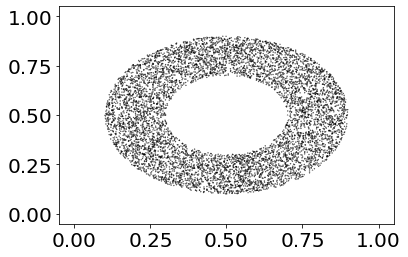

In [13]:
fig, ax = plt.subplots()

ax.scatter(data['x0'].values, data['x1'].values, c=data['C'].values, cmap = 'Greys', s=0.1)
#ax.legend(['Zero Effect Group', 'Positive Effect Group'])
fig.savefig(path_figs+'data.jpeg',bbox_inches='tight', pad_inches = 0)

plt.show()

In [14]:
%%time
f1_kwargs = {'n_estimators':400, 'max_depth':18}
f2_kwargs = {'n_estimators':400, 'max_depth':18}

data, models = predict_cf(data.copy(), col_select = ['x0', 'x1'], f1 = GDBR,
                          f2 = GDBR, cf_name = 'Ycf-GDBR', f1_kwargs=f1_kwargs, 
                          f2_kwargs=f2_kwargs, ite_name ='ITE-GDBR')

CPU times: user 48.6 s, sys: 173 ms, total: 48.7 s
Wall time: 1min 20s


In [15]:
data.head(5)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR
0,0.548814,0.715189,1,0,-3.943020,-5.723423,-1.780403,0,2.014000,5.957020
1,0.602763,0.544883,0,0,3.046737,10.968478,7.921741,0,7.429187,4.382450
2,0.423655,0.645894,0,0,-12.710297,0.664505,13.374801,0,5.107658,17.817955
3,0.437587,0.891773,1,0,7.349087,5.711404,-1.637683,0,1.011125,-6.337962
4,0.963663,0.383442,0,0,3.842964,3.380475,-0.462489,0,2.418299,-1.424664


### Model performance

In [16]:
filt = (data['Treatment'] == 1) & (data['C'] == 1) & (data['IS_TEST'] ==0)
data.groupby(['Treatment', 'C'])[['Y', 'Ycf', 'Ycf-GDBR','ITE', 'ITE-GDBR']].mean()

Y       Ycf  Ycf-GDBR       ITE  ITE-GDBR
Treatment C                                                  
0         0  0.964330  0.998911  0.864085  0.034580 -0.100246
          1  0.035216  1.067561  1.056400  1.032345  1.021185
1         0  0.899922  0.991469  0.992685 -0.091547 -0.092763
          1  0.992890  0.142493  0.022503  0.850397  0.970387

### Apply clustering 

In [17]:
%%time
col_select = ['x0', 'x1']
data,_ = box_clustering(data.copy(), clusters = clusters, col_select = col_select )
data,_ = kmeans_clustering(data.copy(), clusters = clusters, col_select = col_select )


CPU times: user 26min 10s, sys: 1.89 s, total: 26min 12s
Wall time: 2min 10s


In [18]:
data.head()

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster
0,0.548814,0.715189,1,0,-3.943020,-5.723423,-1.780403,0,2.014000,5.957020,83,116
1,0.602763,0.544883,0,0,3.046737,10.968478,7.921741,0,7.429187,4.382450,61,103
2,0.423655,0.645894,0,0,-12.710297,0.664505,13.374801,0,5.107658,17.817955,81,48
3,0.437587,0.891773,1,0,7.349087,5.711404,-1.637683,0,1.011125,-6.337962,103,87
4,0.963663,0.383442,0,0,3.842964,3.380475,-0.462489,0,2.418299,-1.424664,54,20


### Calculte ATT PER Cluster  known CF

$
\begin{align}
E[Y^1|T=1,Ci ]-E[Y^0|T=1, Ci]
\end{align}
$

In [19]:
ite_name = 'ITE'
box = ATTC(data.copy(), cluster_name = 'Box-Cluster', ATT_CLUST_name='Box-ATT',
           points_name='Box-points', weight_names='Box-Weights', 
           ITE_name = ite_name, hom_name = 'Box-Hom',
          att = False)

kmeans = ATTC(data.copy(), cluster_name = 'Kmeans-Cluster', ATT_CLUST_name='Kmeans-ATT',
           points_name='Kmeans-points', weight_names='Kmeans-Weights',ITE_name = ite_name,
              hom_name = 'Kmeans-Hom', att = False)


In [20]:
box

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights
0,0,-0.781439,151.0,1.0,0.00755
1,1,-0.412695,179.0,1.0,0.00895
2,2,-0.570823,129.0,1.0,0.00645
3,3,-0.607766,144.0,1.0,0.00720
4,4,0.307817,164.0,1.0,0.00820
...,...,...,...,...,...
116,116,-0.434767,157.0,1.0,0.00785
117,117,0.505918,171.0,1.0,0.00855
118,118,-0.280284,172.0,1.0,0.00860
119,119,0.142618,150.0,1.0,0.00750


/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


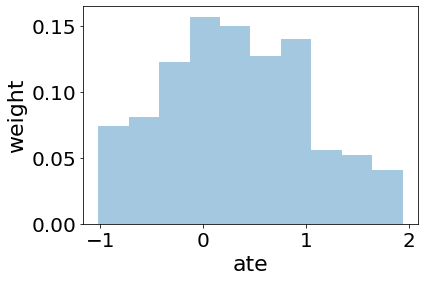

In [21]:
path2 = path_figs+'histograms/'
Path(path2).mkdir(exist_ok = True)

kde = False
bins = 10
fig, ax = plt.subplots(1,1)
ax = sns.distplot(box['Box-ATT'].values, hist_kws = {'weights':box['Box-Weights'].values} , bins=bins, kde = False,ax = ax)
ax.set_xlabel('ate')
ax.set_ylabel('weight')
fig.savefig(path2+'boxhist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()



/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


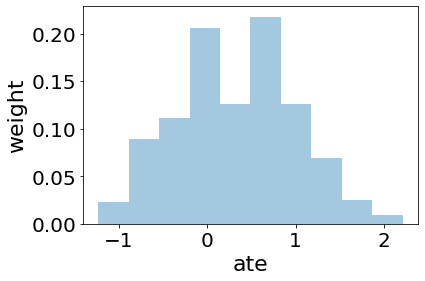

In [22]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(kmeans['Kmeans-ATT'], hist_kws={'weights':kmeans['Kmeans-Weights'].values},
                  bins = bins, kde = kde, ax = ax)

ax.set_xlabel('ate')
ax.set_ylabel('weight')
fig.savefig(path2+'Kmhist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()


/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


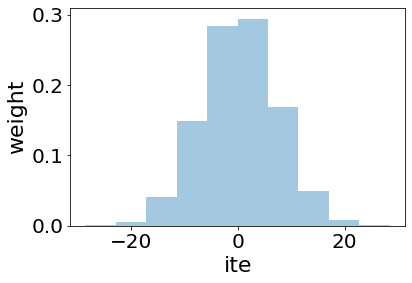

In [23]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(data['ITE'], bins = bins, kde = kde, hist_kws={'weights': np.ones(len(data))/len(data)},
                  ax = ax)
ax.set_xlabel('ite')
ax.set_ylabel('weight')
fig.savefig(path2+'itehist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()


In [24]:
box.describe()

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights
count,121.000000,121.000000,121.000000,121.000000,121.000000
mean,60.000000,0.331002,165.289256,0.902170,0.008264
std,35.073732,0.697525,13.062949,0.161049,0.000653
min,0.000000,-1.019034,129.000000,0.505618,0.006450
25%,30.000000,-0.213914,156.000000,0.785714,0.007800
50%,60.000000,0.362717,166.000000,1.000000,0.008300
75%,90.000000,0.840973,175.000000,1.000000,0.008750
max,120.000000,1.935557,206.000000,1.000000,0.010300


### Calculate ATT per Cluster not known Model Calculated CF

In [25]:
ite_name = 'ITE-GDBR'
box2 = ATTC(data.copy(), cluster_name = 'Box-Cluster', ATT_CLUST_name='Box-ATT',
           points_name='Box-points', weight_names='Box-Weights', ITE_name = ite_name,
            hom_name = 'Box-Hom', att = False)

kmeans2 = ATTC(data.copy(), cluster_name = 'Kmeans-Cluster', ATT_CLUST_name='Kmeans-ATT',
           points_name='Kmeans-points', weight_names='Kmeans-Weights',ITE_name = ite_name,
               hom_name = 'Kmeans-Hom', att = False)



/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


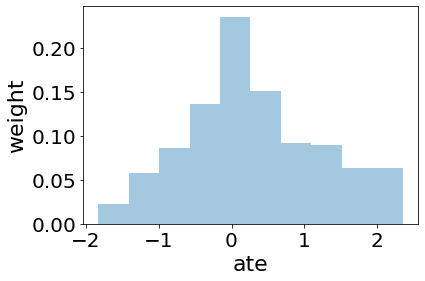

In [26]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(box2['Box-ATT'], hist_kws={'weights':box2['Box-Weights'].values},bins = bins, kde = kde,ax = ax )
ax.set_xlabel('ate')
ax.set_ylabel('weight')
fig.savefig(path2+'Box2hist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()




/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


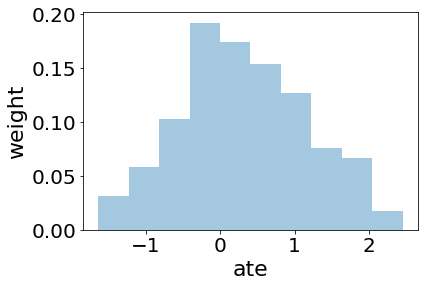

In [27]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(kmeans2['Kmeans-ATT'], hist_kws={'weights':kmeans2['Kmeans-Weights'].values},
             bins = bins, kde = kde, ax = ax)
ax.set_xlabel('ate')
ax.set_ylabel('weight')
fig.savefig(path2+'KM2hist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


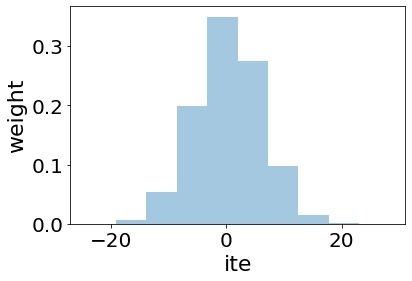

In [28]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(data['ITE-GDBR'],bins = bins,hist_kws={'weights': np.ones(len(data))/len(data)},
                  kde = kde, ax = ax)

ax.set_xlabel('ite')
ax.set_ylabel('weight')
fig.savefig(path2+'ITE2hist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()

### Weighted Kmeans 2-Clustering

In [29]:
%%time
#all_data = [box, kmeans, agglo, box2, kmeans2, agglo2]
all_data = [box, kmeans, box2, kmeans2]

#names = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2', 'Kmeans2-Cl2', 'Agglo2-Cl2']
#names2 = ['Box-ATT', 'Kmeans-ATT', 'Agglo-ATT', 'Box-ATT', 'Kmeans-ATT', 'Agglo-ATT']

names = ['Box-Cl2', 'Kmeans-Cl2',  'Box2-Cl2', 'Kmeans2-Cl2']
names2 = ['Box-ATT', 'Kmeans-ATT',  'Box-ATT', 'Kmeans-ATT']

weights = ['Box-Weights', 'Kmeans-Weights', 'Box-Weights', 'Kmeans-Weights']

for dd, name, name2,w in zip(all_data, names, names2,weights):
    kmeans_clustering(dd, clusters = 2, col_select = [name2], 
                      cluster_name = name, fit_kwargs={'sample_weight':dd[w].values} )

CPU times: user 192 ms, sys: 3.72 ms, total: 196 ms
Wall time: 422 ms


In [30]:
data2 = data.copy()

In [31]:
data2.head(2)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster
0,0.548814,0.715189,1,0,-3.943020,-5.723423,-1.780403,0,2.014000,5.95702,83,116
1,0.602763,0.544883,0,0,3.046737,10.968478,7.921741,0,7.429187,4.38245,61,103


### 2 Clustering in the ITEs

In [32]:
data2,_ = kmeans_clustering(data2,clusters = 2, cluster_name = 'ITE-CTrue',col_select = ['ITE'] )
data2,_ = kmeans_clustering(data2,clusters = 2, cluster_name = 'ITE-CGDBR',col_select = ['ITE-GDBR'] )

### Clustering for Drawing 
1. Apply Box clustering to separate the space in K clusters
2. Group by this clusters and get the Average C2-Avg from the 2 clustering
3. Color each box with the C2-Avg corresponding to each box

In [33]:
K = 10**4
data2,_ = box_clustering(data2, clusters = K, cluster_name = 'C2-Avg', col_select = col_select)

In [34]:
data2.head(2)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster,ITE-CTrue,ITE-CGDBR,C2-Avg
0,0.548814,0.715189,1,0,-3.943020,-5.723423,-1.780403,0,2.014000,5.95702,83,116,0,1,7154
1,0.602763,0.544883,0,0,3.046737,10.968478,7.921741,0,7.429187,4.38245,61,103,1,1,5460


In [35]:
box.head(2)

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights,Box-Cl2
0,0,-0.781439,151.0,1.0,0.00755,0
1,1,-0.412695,179.0,1.0,0.00895,0


### Merge 2 Clustering with initial data

In [36]:
#merge_names = ['Box-Cluster', 'Kmeans-Cluster', 'Agglomerative-Cluster']*2
#class_names = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2', 'Kmeans2-Cl2', 'Agglo2-Cl2']

merge_names = ['Box-Cluster', 'Kmeans-Cluster']*2
class_names = ['Box-Cl2', 'Kmeans-Cl2',  'Box2-Cl2', 'Kmeans2-Cl2']

for dd, merge_name, class_name in zip(all_data, merge_names, class_names):
    dd2 = dd[[merge_name, class_name]]


    data2 = data2.merge(dd2, on = merge_name, how = 'left' )

### Find Average 2 Clustering per draw cluster and merge them in the initial dataset

In [37]:
#merge_names = ['Box-Cluster', 'Kmeans-Cluster', 'Agglomerative-Cluster']*2
#class_names1 = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2', 'Kmeans2-Cl2',
            #    'Agglo2-Cl2','ITE-CTrue', 'ITE-CGDBR']
class_names = ['Box-Cl2', 'Kmeans-Cl2',  'Box2-Cl2', 
               'Kmeans2-Cl2','ITE-CTrue', 'ITE-CGDBR']

avg_c = data2.groupby('C2-Avg', sort = True)[class_names].mean().reset_index()
data2 = data2.merge(avg_c, on = 'C2-Avg', how = 'left', suffixes=("","y"))

In [38]:
avg_c.head()

,C2-Avg,Box-Cl2,Kmeans-Cl2,Box2-Cl2,Kmeans2-Cl2,ITE-CTrue,ITE-CGDBR
0,0,0.0,0.0,0.0,0.0,0.8,0.4
1,1,0.0,0.0,0.0,0.0,0.0,1.0
2,4,0.0,0.0,0.0,0.0,0.0,0.0
3,6,0.0,0.0,0.0,0.0,0.0,1.0
4,7,0.0,0.0,0.0,0.0,1.0,1.0


In [39]:
data2.head(2)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster,ITE-CTrue,ITE-CGDBR,C2-Avg,Box-Cl2,Kmeans-Cl2,Box2-Cl2,Kmeans2-Cl2,Box-Cl2y,Kmeans-Cl2y,Box2-Cl2y,Kmeans2-Cl2y,ITE-CTruey,ITE-CGDBRy
0,0.548814,0.715189,1,0,-3.943020,-5.723423,-1.780403,0,2.014000,5.95702,83,116,0,1,7154,0,1,0,0,0.666667,1.0,0.666667,0.0,0.0,0.333333
1,0.602763,0.544883,0,0,3.046737,10.968478,7.921741,0,7.429187,4.38245,61,103,1,1,5460,1,0,0,1,1.000000,0.0,0.000000,1.0,0.5,1.000000


### Plot reconstruction of data

In [40]:
mpl.rcParams["figure.dpi"]

72.0

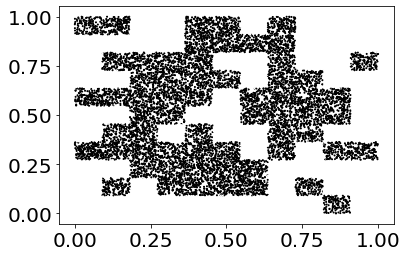

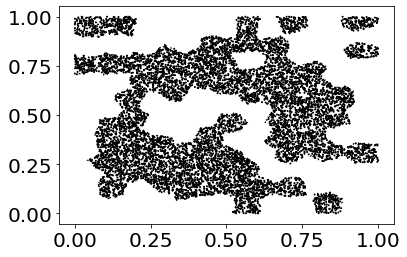

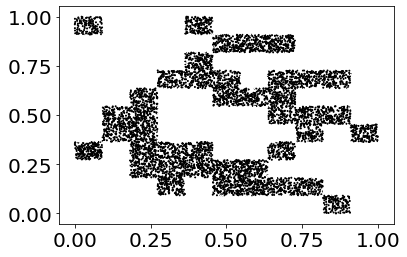

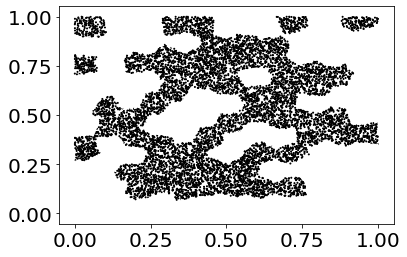

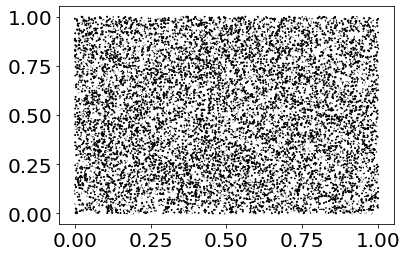

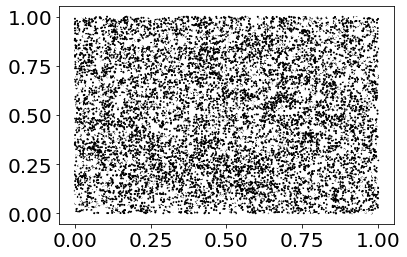

CPU times: user 15.8 s, sys: 61.3 ms, total: 15.9 s
Wall time: 35.5 s


In [41]:
%%time
#class_names1 = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2',
                #'Kmeans2-Cl2', 'Agglo2-Cl2', 'ITE-CTrue', 'ITE-CGDBR']


path3 = path_figs+'reconstruction/'
Path(path3).mkdir(exist_ok = True, parents = True)
class_names2 = [name+'y' for name in class_names]
use_poly = False
for name in class_names:
    #data2.plot.scatter(x='x0', y='x1', c=name, colormap='inferno')
    fig, ax = plt.subplots()
    if not use_poly:
        sc = ax.scatter(data2['x0'].values, data2['x1'].values, c=data2[name].values, cmap = 'Greys', s = 1)
        #sc = ax.hist2d(data2['x0'].values, data2['x1'].values,bins = 50,  cmap = 'Greys')

    else:
        polygons, colors = generate_paths(K, Cdraw = avg_c, Cdraw_name=name)
        coll = mpl.collections.PolyCollection(polygons)
        coll.set(array = np.array(colors), cmap = 'Greys')
        ax.add_collection(coll)
        ax.figure.colorbar(coll)
    #ax.set_title(name)
    #fig.colorbar(sc)
    fig.savefig(path3+'{}.jpeg'.format(name), bbox_inches='tight',pad_inches = 0)

    plt.show()
    

### Plot same as above but with box averaging

IndexError: single positional indexer is out-of-bounds

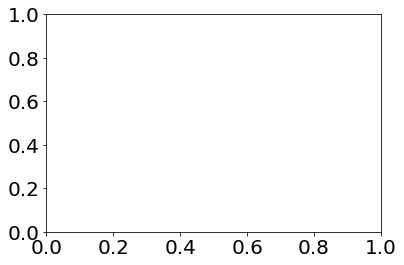

In [42]:
%%time
#class_names1 = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2',
                #'Kmeans2-Cl2', 'Agglo2-Cl2', 'ITE-CTrue', 'ITE-CGDBR']



class_names2 = [name+'y' for name in class_names]
use_poly = True
for name in class_names:
    #data2.plot.scatter(x='x0', y='x1', c=name, colormap='inferno')
    fig, ax = plt.subplots()
    if not use_poly:
        sc = ax.scatter(data2['x0'].values, data2['x1'].values, c=data2[name].values, cmap = 'Greys', s = 0.25)
    else:
        polygons, colors = generate_paths(K, Cdraw = avg_c, Cdraw_name=name)
        coll = mpl.collections.PolyCollection(polygons)
        coll.set(array = np.array(colors), cmap = 'Greys')
        ax.add_collection(coll)
       # ax.figure.colorbar(coll)
    ax.set_title(name)
    #fig.colorbar(sc)

    plt.show()
    

### homogeneity experiment

clusters = [4, 16, 25, 100]
clustering_algo = ['box_clustering', 'kmeans_clustering', 'agglomerative_clustering']

result = get_homogeneity(data.copy(),clusters = clusters, clustering_algo = clustering_algo, col_select = col_select)

pd.DataFrame(result)